## Create a Local RAG for Documentation Search - Q&A Inference Pipeline (Tensorflow+Huggingface)


#### - Usecase : Company Internal Document Chat

In [4]:
import torch

In [5]:
!nvidia-smi

Sun Jul 14 09:21:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   30C    P8             18W /  250W |    1394MiB /  11264MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Outline Steps:
* [Open a PDF Document](#first-bullet) 
* [Format the Text of PDF to be fit for Embedding Model](#second-bullet)
* [Embed all chunks of the text and turn them into numerical representation](#third-bullet) 
* [Build a retreival model that uses vector search to find relevant piece of chunks based on user query](#fourth-bullet)
* [Create a prompt that has the retreived piece of text](#fifth-bullet)
* [Generate a answer based on the returned output](#sixth-bullet) 

## Open a PDF Document <a class="anchor" id="#first-bullet"></a>

In [28]:
pdf_name = "FY24_AnnualReport__FINAL-web.pdf"

In [3]:
import os
import requests

if not os.path.exists(pdf_name):
    print(f"[INFO] File doesn't exist, downloading...")

    url = "https://s203.q4cdn.com/703080298/files/doc_financials/2024/ar/FY24_AnnualReport__FINAL-web.pdf"

    filename = pdf_name
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download file. Error Status Code: {response.status_code}")

else:
    print(f"File {pdf_name} exists.")

[INFO] File doesn't exist, downloading...
[INFO] The file has been downloaded and saved as FY24_AnnualReport__FINAL-web.pdf


In [39]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_read_pdf(pdf_name: str) -> list[dict]:
    doc = fitz.open(pdf_name)
    page_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        page_texts.append({
            "page_number": page_number - 8,
            "page_chat_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count": len(text.split(". ")),
            "page_token_count": len(text) / 4,  # 1 Token = ~4 Char
            "text": text
        })
    return page_texts

# Define the path to your PDF file

# Call the function to read the PDF
page_texts = open_read_pdf(pdf_name)

# Print the text of the first page
print(page_texts[:1])

0it [00:00, ?it/s]

[{'page_number': -8, 'page_chat_count': 0, 'page_word_count': 1, 'page_sentence_count': 1, 'page_token_count': 0.0, 'text': ''}]


In [41]:
import random
random.sample(page_texts, k=1 )

[{'page_number': 86,
  'page_chat_count': 3193,
  'page_word_count': 578,
  'page_sentence_count': 19,
  'page_token_count': 798.25,
  'text': 'Under the 2020 Plan, we have the option to settle share-based awards by issuing common shares from treasury, issuing new  Company common shares, or issuing a combination of common shares from treasury and new Company common shares. Stock Options: Under the 2020 Plan, we granted 84,568, 113,970, and 152,971 stock options during 2024, 2023, and 2022,  respectively. Stock options granted in 2024, 2023, and 2022 vest ratably over a period of three years. The exercise price of all  stock options granted was equal to the market value of the shares on the date of grant, and all stock options granted and  outstanding have a contractual term of 10 years. The fair value of each stock option is estimated on the date of grant using a Black-Scholes option-pricing model with the  following weighted-average assumptions for stock options granted:  2024 2023 20

In [43]:
import pandas as pd
df = pd.DataFrame(page_texts)
df.head()

,page_number,page_chat_count,page_word_count,page_sentence_count,page_token_count,text
0,-8,0,1,1,0.00,
1,-7,1,1,1,0.25,1
2,-6,3905,666,19,976.25,3 F i s c a l Ye a r 2 0 2 4 A nnual Rep ort ...
3,-5,3614,638,19,903.50,F i s c a l Ye a r 2 0 2 4 A nnual Rep ort ...
4,-4,5084,900,28,1271.00,Playing to Win There are countless examples o...


In [46]:
df.describe()

,page_number,page_chat_count,page_word_count,page_sentence_count,page_token_count
count,108.00000,108.000000,108.000000,108.000000,108.000000
mean,45.50000,3937.398148,657.546296,22.509259,984.349537
std,31.32092,1431.126326,215.169283,9.540367,357.781581
min,-8.00000,0.000000,1.000000,1.000000,0.000000
25%,18.75000,3003.000000,530.250000,16.000000,750.750000
50%,45.50000,3897.000000,694.000000,24.000000,974.250000
75%,72.25000,5146.000000,822.500000,30.000000,1286.500000
max,99.00000,6099.000000,963.000000,46.000000,1524.750000


In [47]:
### Mean Token count is 985 
### Mean Word Count is 658 

### Types of Techniques - Document Parsing 
* Max Token window with Overlap
* Natural Whitespace Chunking with no overlap
* Use Clustering to create semantic Docs
* Entire Doc without Chunking

## Format the Text of PDF to be fit for Embedding Model <a class="anchor" id="#second-bullet"></a>

In [51]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. This is second sentence. I love people")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence., This is second sentence., I love people]

In [55]:
page_texts[1]

{'page_number': -7,
 'page_chat_count': 1,
 'page_word_count': 1,
 'page_sentence_count': 1,
 'page_token_count': 0.25,
 'text': '1'}

In [56]:
for item in tqdm(page_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"])
    

  0%|          | 0/108 [00:00<?, ?it/s]

In [57]:
random.sample(page_texts, k=1)

[{'page_number': 96,
  'page_chat_count': 1706,
  'page_word_count': 378,
  'page_sentence_count': 19,
  'page_token_count': 426.5,
  'text': '111 F i s c a l  Ye a r 2 0 2 4 A nnual Rep ort SIGNATURES Pursuant to the requirements of Section 13 or 15(d) of the Securities Exchange Act of 1934, the registrant has duly caused  this report to be signed on its behalf by the undersigned, thereunto duly authorized. Date: June 18, 2024                                The J. M. Smucker Company /s/ Tucker H. Marshall By: Tucker H. Marshall Chief Financial Officer Pursuant to the requirements of the Securities Exchange Act of 1934, this report has been signed below by the  following persons on behalf of the registrant and in the capacities and on the dates indicated. * Mark T. Smucker Chair of the Board, President, and Chief Executive Officer (Principal Executive Officer) June 18, 2024 * Tucker H. Marshall Chief Financial Officer (Principal Financial Officer and Principal  Accounting Officer) June

In [58]:
df = pd.DataFrame(page_texts)
df.describe().round(2)

,page_number,page_chat_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,108.00,108.00,108.00,108.00,108.00,108.00
mean,45.50,3937.40,657.55,22.51,984.35,18.70
std,31.32,1431.13,215.17,9.54,357.78,9.36
min,-8.00,0.00,1.00,1.00,0.00,0.00
25%,18.75,3003.00,530.25,16.00,750.75,11.00
50%,45.50,3897.00,694.00,24.00,974.25,19.00
75%,72.25,5146.00,822.50,30.00,1286.50,27.00
max,99.00,6099.00,963.00,46.00,1524.75,34.00


In [63]:
### Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

## Create a fn to split list of texts recursiverly into chunk size 
#### Eg. [25] -> [10],[10],[5]
def split_list(input_list: list[str], slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range (0, len(input_list), slice_size)] 

# test_list = list(range(25))
# split_list(test_list)

In [64]:
## Loop through pages and texts and split sentences into chunks
for item in tqdm(page_texts):
    item['sentence_chunks'] = split_list(input_list = item['sentences'], 
                                         slice_size = num_sentence_chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/108 [00:00<?, ?it/s]

In [89]:
#random.sample(page_texts, k=1)

In [66]:
df = pd.DataFrame(page_texts)
df.describe().round(2)

,page_number,page_chat_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,108.00,108.00,108.00,108.00,108.00,108.00,108.00
mean,45.50,3937.40,657.55,22.51,984.35,18.70,2.33
std,31.32,1431.13,215.17,9.54,357.78,9.36,0.91
min,-8.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,18.75,3003.00,530.25,16.00,750.75,11.00,2.00
50%,45.50,3897.00,694.00,24.00,974.25,19.00,2.00
75%,72.25,5146.00,822.50,30.00,1286.50,27.00,3.00
max,99.00,6099.00,963.00,46.00,1524.75,34.00,4.00


In [73]:
#### Splitting Each Chunk into its own item - 3 Chunks
import re 
page_and_chunks = []
for item in tqdm(page_texts):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number'] 
        
        ## Join sentence together into a paragraphy like structure 
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])',r'. \1', joined_sentence_chunk)

        chunk_dict['sentence_chunk'] = joined_sentence_chunk
        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4
        page_and_chunks.append(chunk_dict)

len(page_and_chunks)
        

  0%|          | 0/108 [00:00<?, ?it/s]

252

In [74]:
random.sample(page_and_chunks, k=1)

[{'page_number': 59,
  'sentence_chunk': 'For information on our defined benefit plans, see Note 9: Pensions and Other Postretirement Benefits. Income Taxes: We account for income taxes using the liability method. Accordingly, deferred tax assets and liabilities are recognized for the future tax consequences attributable to differences between financial statement carrying amounts of existing assets and liabilities and their respective tax bases. Deferred tax assets and liabilities are measured using enacted income tax rates expected to apply to taxable income in the years in which those temporary differences are expected to be recovered or settled. The effect on deferred tax assets and liabilities of a change in the applicable tax rate is recognized in income or expense in the period that the change is enacted. A tax benefit is recognized when it is more likely than not to be sustained. A valuation allowance is established when it is more likely than not that all or a portion of a defe

In [76]:
df2 = pd.DataFrame(page_and_chunks)
df2.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,252.00,252.00,252.00,252.00
mean,43.52,1663.84,258.76,415.96
std,29.77,780.36,127.22,195.09
min,-7.00,1.00,1.00,0.25
25%,17.75,1217.75,184.75,304.44
50%,40.50,1729.00,270.50,432.25
75%,68.00,2129.00,336.50,532.25
max,99.00,3805.00,709.00,951.25


In [84]:
### Show random chunks under 30 token in length - these shotter chunks maynot contain useful information
min_token_len = 30 
for row in df2[df2['chunk_word_count'] <= min_token_len].sample(5).iterrows():
    #print(f'Chunk Token Count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}')
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')


Chunk token count: 0.5 | Text: 70
Chunk token count: 0.5 | Text: 26
Chunk token count: 0.5 | Text: 67
Chunk token count: 24.75 | Text: At April 30, 2024, there were 3,740,981 shares available for future issuance under the 2020 Plan.85
Chunk token count: 0.5 | Text: 41


In [85]:
### Can eleminate the unncecessary data 
page_and_chunks_over_min_token_len = df2[df2["chunk_token_count"] > min_token_len].to_dict(orient= "records")
page_and_chunks_over_min_token_len[:2]

[{'page_number': -6,
  'sentence_chunk': '3 F i s c a l Ye a r 2 0 2 4 A nnual Rep ort With a focus on establishing leading positions in attractive categories, we have cultivated a strong portfolio of brands across our strategic business areas of coffee, frozen handheld and spreads, pet, and sweet baked snacks. In fiscal year 2024, these businesses achieved success and paved the way for continued growth. Frozen Handheld and Spreads ________________ We continue to invest in the growth of our frozen handheld business with Uncrustables® and our leading positions in peanut butter, with Jif ®, and fruit spreads, with our namesake Smucker’s® brand. Uncrustables® delivered approximately $800 million in net sales, buoyed by expanded distribution and the launch of dedicated marketing for the brand, and is well on pace to achieve our goal of $1 billion in annual net sales by the end of our fiscal year 2026. Jif ® leads all competitors in household penetration and volume velocity. And, our teams 

In [88]:
random.sample(page_and_chunks_over_min_token_len, k=1)

[{'page_number': -3,
  'sentence_chunk': 'Our Transformation and Growth Vision  In fiscal year 2024, I assumed oversight of  our new integrated portfolio management organization, which will support the execution of our transformation initiatives. When we think about transformation at Smucker, we think about ways of working and how we can continue to promote a spirit of continuous improvement. This new organization will create seamless collaboration across the business  and as we review planning against margin management objectives. It is important to reflect on the fact that this work  is in service of our broader growth aspirations. We are committed to identifying opportunities  for cost savings that will allow us to reinvest  in the business and deliver shareholder value in the long term. This strategy has supported the expansion of our current portfolio and the establishment of our leading positions across coffee, frozen handheld and spreads, pet, and sweet baked snacks. Our continu

## Embed all chunks of the text and turn them into numerical representation <a class="anchor" id="#third-bullet"></a>

##### -- Numerical Representation : Embeddings itself can be called `Learned` representation
##### *Link: https://vickiboykis.com/what_are_embeddings/index.html*

In [91]:
### https://sbert.net/docs/sentence_transformer/pretrained_models.html

In [93]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                     device = "cuda")

In [94]:
ex_sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

In [97]:
# embeddings = embedding_model.encode(ex_sentences)
# embedding_dict = dict(zip(ex_sentences, embeddings))

# for ex_sentence, embedding in embedding_dict.items():
#     print(f"Sentence:{ex_sentence}")
#     print(f"Embedding:{embedding}")
#     print(" ")

In [99]:
%%time
embedding_model.to("cuda")

for item in tqdm(page_and_chunks_over_min_token_len):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/239 [00:00<?, ?it/s]

CPU times: total: 17.3 s
Wall time: 6.31 s


In [100]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in page_and_chunks_over_min_token_len]

In [101]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: total: 5.31 s
Wall time: 3.22 s


tensor([[ 0.0679,  0.0821, -0.0079,  ...,  0.0147, -0.0226, -0.0186],
        [ 0.0292, -0.0011, -0.0425,  ...,  0.0050, -0.0100,  0.0088],
        [ 0.0331,  0.0991, -0.0254,  ...,  0.0194, -0.0384, -0.0210],
        ...,
        [ 0.0673,  0.0751, -0.0098,  ..., -0.0098, -0.0935, -0.0235],
        [ 0.0320,  0.0244,  0.0168,  ...,  0.0013, -0.0532, -0.0585],
        [ 0.0530,  0.0311, -0.0169,  ..., -0.0043, -0.0605, -0.0276]],
       device='cuda:0')

#### We can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.
##### `CPU to GPU > GPU to Batched Operations` 

### Save Embeddings to File

In [105]:
text_chunks_and_embeddings_df = pd.DataFrame(page_and_chunks_over_min_token_len)
embeddings_df_save_path = 'text_chunks_and_embeddings_df.csv'
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index= False)

In [ ]:
## Importing save file and view

In [160]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-6,3 F i s c a l Ye a r 2 0 2 4 A nnual Rep ort W...,1997,324,499.25,[ 6.79073781e-02 8.21321085e-02 -7.93926977e-...
1,-6,Sweet Baked Snacks ________________________ Sn...,1849,284,462.25,[ 2.92028822e-02 -1.07182015e-03 -4.24703397e-...
2,-5,F i s c a l Ye a r 2 0 2 4 A nnual Rep ort 5...,2029,345,507.25,[ 3.31293382e-02 9.90552604e-02 -2.53941510e-...
3,-5,Our entry into this category also amplifies ou...,1511,220,377.75,[ 2.08477713e-02 4.94901724e-02 -2.25071032e-...
4,-4,Playing to Win There are countless examples of...,1517,247,379.25,[ 1.54077811e-02 1.09549724e-01 -3.59133966e-...


In [157]:
text_chunks_and_embedding_df_load['embedding']

0      [7.274868213320213e-43, 6.000503458385137e-67,...
1      [6.00749890362188e-67, 6.000503479975902e-67, ...
2      [3.503687808615231e-33, 6.000503480492379e-67,...
3      [9.066730728214348e-43, 6.000503501997793e-67,...
4      [7.266096412840843e-43, 6.000503457780948e-67,...
                             ...                        
234    [4.85335515748854e-33, 6.00050354638736e-67, 1...
235    [2.582046159013547e-57, 6.000503524192747e-67,...
236    [1.3821442427327793e-47, 6.000503436103823e-67...
237    [1.3813371930283845e-47, 6.000503546561099e-67...
238    [1.0413742561915109e-42, 6.000503502256544e-67...
Name: embedding, Length: 239, dtype: object

## Build a retreival model that uses vector search to find relevant piece of chunks based on user query <a class="anchor" id="#fourth-bullet"></a>

In [161]:
import torch
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

In [162]:
text_chunks_and_embedding_df_load['embedding'] = text_chunks_and_embedding_df_load['embedding'].astype(str)

In [155]:
#text_chunks_and_embedding_df_load['embedding'] = text_chunks_and_embedding_df_load['embedding'].apply(lambda x:np.fromstring(x))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13752\1188215411.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  text_chunks_and_embedding_df_load['embedding'] = text_chunks_and_embedding_df_load['embedding'].apply(lambda x:np.fromstring(x))


In [163]:
text_chunks_and_embedding_df_load["embedding"] = text_chunks_and_embedding_df_load["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

In [179]:
## Conv embeddings to torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df_load['embedding'].tolist(), axis=0), dtype=torch.float32).to(device)

In [164]:
pages_and_chunks = text_chunks_and_embedding_df_load.to_dict(orient = "records")

In [165]:
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-6,3 F i s c a l Ye a r 2 0 2 4 A nnual Rep ort W...,1997,324,499.25,"[0.0679073781, 0.0821321085, -0.00793926977, -..."
1,-6,Sweet Baked Snacks ________________________ Sn...,1849,284,462.25,"[0.0292028822, -0.00107182015, -0.0424703397, ..."
2,-5,F i s c a l Ye a r 2 0 2 4 A nnual Rep ort 5...,2029,345,507.25,"[0.0331293382, 0.0990552604, -0.025394151, -0...."
3,-5,Our entry into this category also amplifies ou...,1511,220,377.75,"[0.0208477713, 0.0494901724, -0.0225071032, -0..."
4,-4,Playing to Win There are countless examples of...,1517,247,379.25,"[0.0154077811, 0.109549724, -0.0359133966, -0...."


In [168]:
embeddings.shape

torch.Size([239, 768])

In [166]:
# embeddings = np.stack(text_chunks_and_embedding_df_load['embedding'].tolist(), axis=0)
# embeddings

array([[ 0.06790738,  0.08213211, -0.00793927, ...,  0.01465533,
        -0.02263444, -0.0186014 ],
       [ 0.02920288, -0.00107182, -0.04247034, ...,  0.00500623,
        -0.01001421,  0.00880301],
       [ 0.03312934,  0.09905526, -0.02539415, ...,  0.01935057,
        -0.03844151, -0.02104484],
       ...,
       [ 0.06734648,  0.07505167, -0.00978276, ..., -0.00980922,
        -0.09349567, -0.02347752],
       [ 0.0320469 ,  0.02435998,  0.01680931, ...,  0.0012963 ,
        -0.05317358, -0.05849613],
       [ 0.05297796,  0.03107661, -0.01693458, ..., -0.00430087,
        -0.06053482, -0.02760598]])

In [170]:
### Create Model
from sentence_transformers import util, SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device = device)

C:\Users\Administrator\Desktop\Projects\Local_LLM_RAG\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [198]:
query = "commodities" 
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

### Get similarity scores with dot product (using cosine similarity)

from time import perf_counter as timer

start_time = timer()

dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} sec.")

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

[INFO] Time taken to get scores on 239 embeddings: 0.00015 sec.


torch.return_types.topk(
values=tensor([0.5675, 0.5434, 0.5227, 0.4445, 0.4396], device='cuda:0'),
indices=tensor([104,  60,  19,  59, 166], device='cuda:0'))

In [199]:
query_embedding.dtype

torch.float32

In [200]:
embeddings[0].dtype

torch.float32

In [210]:
#pages_and_chunks[104]

In [202]:
import textwrap

def print_wrapped(text, wrap_length = 80):
    wrapped_text= textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [204]:
query = "commodities"
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page no:{page_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'commodities'

Results:
Score: 0.5675
Text:
Commodities Overview The raw materials we use in each of our segments are
primarily commodities, agricultural-based products, and packaging materials. The
most significant of these materials, based on 2024 annual spend, are green
coffee, peanuts, oils and fats, flour, sugar, and fruit. Green coffee, corn,
certain meals, oils, and grains are traded on active regulated exchanges, and
the price of these commodities fluctuates based on market conditions. Derivative
instruments, including futures and options, are used to minimize the impact of
price volatility for these commodities. We source green coffee from more than 20
coffee-producing countries. Its price is subject to high volatility due to
factors such as weather, global supply and demand, product scarcity, plant
disease, investor speculation, geopolitical conflicts (including the ongoing
conflicts between Russia and Ukraine and Israel and Hamas), changes in
governmental agricultural

Note: We can potentially improve the order of these results with a reranking model. 

In [206]:
print(pdf_name)

FY24_AnnualReport__FINAL-web.pdf


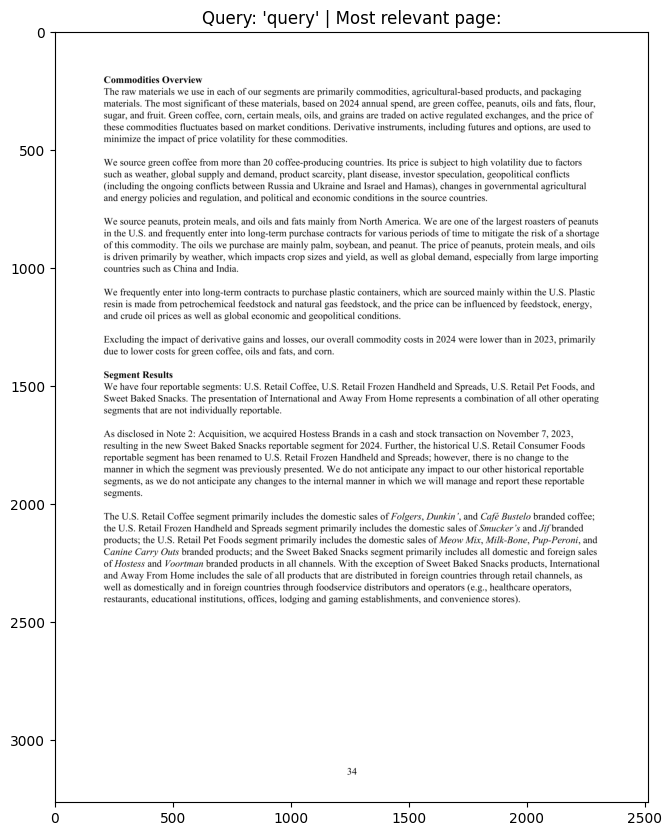

In [211]:
import fitz

doc = fitz.open(pdf_name)
page = doc.load_page(34+8) 

img = page.get_pixmap(dpi=300)
doc.close()

img_array = np.frombuffer(img.samples_mv,
                          dtype = np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize = (13,10))
plt.imshow(img_array)
plt.title(f"Query: 'query' | Most relevant page:")
plt.show()

#### Similarity Measures: dot product and cosine similarity

### Functioning the semantic search pipeline

In [214]:
def retreive_relevant_resources(query:str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer = embedding_model,
                                n_resources_to_return: int=5,
                                print_time : bool = True):
    query_embedding = model.encode(query, convert_to_tensor = True)
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()
    if print_time:
        print(f"[INFO] time taken to get scores on ({len(embeddings)} embeddings : {end_time-start_time:.5f} sec.")
    scores , indices = torch.topk(input = dot_scores,
                                    k = n_resources_to_return)
    return scores, indices

def print_top_results_and_scores(query:str,
                                 embeddings:torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int = 5):
    scores, indices = retreive_relevant_resources(query = query,
                                                  embeddings = embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page no:{page_and_chunks[idx]['page_number']}")
        print("\n")

In [216]:
query = 'sweet snacks based goods'
#retreive_relevant_resources(query = query, embeddings = embeddings)
print_top_results_and_scores(query = query, embeddings = embeddings)

[INFO] time taken to get scores on (239 embeddings : 0.00025 sec.
Score: 0.6582
Text:
Further, the historical U. S. Retail Consumer Foods reportable segment has been
renamed to U. S. Retail Frozen Handheld and Spreads; however, there is no change
to the manner in which the segment was previously presented. For additional
information on our reportable segments, see Note 5: Reportable Segments. The U.
S. retail market segments and Sweet Baked Snacks segment in total comprised 85
percent of consolidated net sales in 2024 and represent a major portion of our
strategic focus – the sale of branded food and beverage products with leadership
positions to consumers through retail outlets in North America. Products within
our U. S. retail market segments are primarily sold through a combination of
direct sales and brokers to food retailers, club stores, discount and dollar
stores, online retailers, pet specialty stores, drug stores, military
commissaries, mass merchandisers, and distributors. Th

## Getting a LLM for local generation

In [218]:
### Hugging face : TheBloke - Provides quantized model 
### Checking GPU Avaliable Mem
gpu_memory_gb = round(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3),2)
print(f"GPU memory: {gpu_memory_gb} GB")

GPU memory: 11.0 GB


`Gemma-7b-it` - Stands for Instruction Tuned

In [219]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 11.0 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [224]:
### Loading the Model 
### Note: Tokenizer is different from the embeddings model
### Note: There are many tricks to loand/make the LLM Work faster. One of the best ones is the flash-attn (Flash Attention 2)
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 

from transformers import BitsAndBytesConfig 
quantization_config = BitsAndBytesConfig(load_in_4bit = True,
                                         bnb_4bit_compute_dtype = torch.float16)


if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = 'flash_attention_2'
else:
    attn_implementation = 'sdpa' ## Scales dot product attention


model_id = model_id

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path = model_id,
                                                 torch_dtype = torch.float16,
                                                 quantization_config = quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage = False,
                                                 attn_implementation = attn_implementation)
                                                        

if not use_quantization_config:
    llm_model.to("cuda")

C:\Users\Administrator\Desktop\Projects\Local_LLM_RAG\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [221]:
torch.cuda.get_device_capability(0)[0]

6

In [225]:
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


In [226]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [227]:
def get_model_num_params(model:torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

In [228]:
get_model_num_params(llm_model)

2506172416

In [231]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5079453696, 'model_mem_mb': 4844.14, 'model_mem_gb': 4.73}

### Generate Text with LLM Locally

In [232]:
input_text = 'How was the financial performance of Smucker in FY23'
print(f"Input Text:\n{input_text}")

### Creating a prompt tempate for IT model
dialogue_template = [
    {"role":"user",
     "content":input_text}]

prompt = tokenizer.apply_chat_template(conversation = dialogue_template,
                                       tokenize = False,
                                       add_generation_prompt = True)
print(f"\nPrompt (formatted):\n{prompt}")

Input Text:
How was the financial performance of Smucker in FY23

Prompt (formatted):
<bos><start_of_turn>user
How was the financial performance of Smucker in FY23<end_of_turn>
<start_of_turn>model



In [234]:
%%time

input_ids = tokenizer(prompt,
                      return_tensors = "pt").to("cuda")
input_ids

CPU times: total: 31.2 ms
Wall time: 79.8 ms


{'input_ids': tensor([[     2,      2,    106,   1645,    108,   2299,    729,    573,   6895,
           4665,    576,   3949,  20348,    575,  36130, 235284, 235304,    107,
            108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [235]:
### Generate outputs
outputs = llm_model.generate(**input_ids,
                             max_new_tokens = 256)
print(f"Model Output (tokens):\n{outputs[0]}\n")

C:\Users\Administrator\Desktop\Projects\Local_LLM_RAG\simple-local-rag\venv\Lib\site-packages\transformers\models\gemma\modeling_gemma.py:561: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Model Output (tokens):
tensor([     2,      2,    106,   1645,    108,   2299,    729,    573,   6895,
          4665,    576,   3949,  20348,    575,  36130, 235284, 235304,    107,
           108,    106,   2516,    108, 235285,   1144,  14321,    577,   3684,
          1879, 235290,   1602,   2113, 235269,   5852,    590,   2952,   3658,
           476,   6895,   4665,  13367,    604,   3949,  20348,    575,  36130,
        235284, 235304, 235265,   1699,    573,   1546,    908, 235290,    511,
        235290,   1545,   6895,   2113, 235269,   3743,   4773,    577,   3949,
         20348, 235303, 235256,   5613,   6895,   8134,    578,  68170, 235265,
             1], device='cuda:0')



In [236]:
### Decode the output to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model Output (decoded):\n{outputs_decoded}\n")

Model Output (decoded):
<bos><bos><start_of_turn>user
How was the financial performance of Smucker in FY23<end_of_turn>
<start_of_turn>model
I am unable to access real-time information, therefore I cannot provide a financial performance summary for Smucker in FY23. For the most up-to-date financial information, please refer to Smucker's official financial reports and announcements.<eos>



## Create a prompt that has the retreived piece of text <a class='anchor' id="#fifth-bullet"></a>

#### Augment our prompt with context items 
* Ref: https://www.promptingguide.ai/
* Ref: https://github.com/brexhq/prompt-engineering
* Ref: https://arxiv.org/abs/2401.14423

#### Prompt Setup:
1. Give Clear Instructions
2. Few Ex: of OP/IP 
3. Give room to think (Step by Step)

In [294]:
query = 'What were the Divestiture Costs for Sahale Snacks'

In [295]:
#### 1st Pass without Prompt Engineering or Templating 

In [296]:
def prompt_formatter(query:str,
                     context_items:list[dict]) -> str:
    context = "- " + "\n- ".join([item['sentence_chunk'] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query. 
    Give yourself room to think by extracting the relevant passages from the context before answering the query. Dont return the thinking, only return the answer. Make sure the answer are as explanatory as possible.
    Use the following examples as reference for the ideal answer style. 
    \nExample 1:
    Query: What was Smucker's total revenue for the fiscal year 2023?
    Answer: According to Smucker's financial report for the fiscal year 2023, the total revenue was $8.03 billion, representing a 3.5% increase compared to the previous fiscal year. 
    \nExample 2:
    Query: How did Smucker's pet food segment perform in the last fiscal year?
    Answer: Smucker's pet food segment reported a revenue of $2.2 billion for the fiscal year 2023, marking a 5% growth year-over-year. This growth was driven by strong performance in brands like Meow Mix and Milk-Bone.
    \nExample 3:
    Query: What are Smucker's strategic priorities for the next fiscal year?
    Answer: Smucker's strategic priorities for the next fiscal year include accelerating growth in core brands, expanding their presence in high-growth categories, investing in digital transformation, and enhancing supply chain efficiencies to drive long-term value for shareholders.
    \nNow use the following context items to answer the user query:
    {context}
    \nRelevant passages: <extract relevant passages from the context here>
    Query: {query}
    Answer:
    """
    prompt = base_prompt.format(context = context, query = query)

    ## Create a prompt template for instruction-tuned model
    # dialogue_template = [
    #     {"role":"user",
    #      "context":base_prompt}]
    # prompt = tokenizer.apply_chat_template(conversation = dialogue_template,
    #                                        tokenize = False,
    #                                        add_generation_prompt= True)
        
    return prompt

query = query
print(f"Query : {query}")

scores, indices = retreive_relevant_resources(query = query,
                                              embeddings= embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query = query,
                          context_items = context_items)
print(prompt)

Query : What were the Divestiture Costs for Sahale Snacks
[INFO] time taken to get scores on (239 embeddings : 0.00009 sec.
Based on the following context items, please answer the query. 
    Give yourself room to think by extracting the relevant passages from the context before answering the query. Dont return the thinking, only return the answer. Make sure the answer are as explanatory as possible.
    Use the following examples as reference for the ideal answer style. 
    
Example 1:
    Query: What was Smucker's total revenue for the fiscal year 2023?
    Answer: According to Smucker's financial report for the fiscal year 2023, the total revenue was $8.03 billion, representing a 3.5% increase compared to the previous fiscal year. 
    
Example 2:
    Query: How did Smucker's pet food segment perform in the last fiscal year?
    Answer: Smucker's pet food segment reported a revenue of $2.2 billion for the fiscal year 2023, marking a 5% growth year-over-year. This growth was driven 

In [259]:
%%time
input_ids = tokenizer(prompt, return_tensors = "pt").to("cuda")

outputs = llm_model.generate(**input_ids,
                             temperature = 0.2,
                             do_sample = True, #https://huyenchip.com/2024/01/16/sampling.html
                             max_new_tokens = 256)

output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt,'')}")

Query: What were the Divestiture Costs for Sahale Snacks
RAG answer:\m<bos>The divesture costs for Sahale Snacks are approximately $6.0, consisting primarily of employee-related and lease termination costs, all of which are expected to be cash charges with the majority recognized in 2024 and the remainder to be recognized during the first half of 2025.<eos>
CPU times: total: 4.14 s
Wall time: 4.24 s


#### After Prompt Templating 


In [261]:
%%time
input_ids = tokenizer(prompt, return_tensors = "pt").to("cuda")

outputs = llm_model.generate(**input_ids,
                             temperature = 0.2,
                             do_sample = True, #https://huyenchip.com/2024/01/16/sampling.html
                             max_new_tokens = 256)

output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt,'')}")

Query: What were the Divestiture Costs for Sahale Snacks
RAG answer:\m<bos>Total divestiture costs related to the divested Sahale Snacks and Canada condiment businesses are anticipated to be approximately $6.0, consisting primarily of employee-related and lease termination costs, all of which are expected to be cash charges with the majority recognized in 2024 and the remainder to be recognized during the first half of 2025.<eos>
CPU times: total: 4.95 s
Wall time: 5.08 s


In [291]:
def ask(query, 
        temperature=0.2,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retreive_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=1024)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [292]:
query = 'Tell me all about the Hostess Brand acquisition?'

In [293]:
print(f"Query:{query}")
ask(query=query)

Query:Tell me all about the Hostess Brand acquisition?
[INFO] time taken to get scores on (239 embeddings : 0.00005 sec.


'The Hostess Brands acquisition involved the acquisition of Hostess Brands for $5.4 billion in cash and stock. The acquisition included six manufacturing facilities located in Kansas, Burlington, Ontario; Chicago, Illinois; Columbus, Georgia; Indianapolis, Indiana; and Arkadelphia, Arkansas. Approximately 3,000 employees transitioned with the business at the close of the transaction.'